In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import types
import random

from pyvis.network import Network
from owlready2 import *

SEED = 40496259

---

# Q1. 

Reading the data file and renaming columns to `subject`, `predicate`, and `object` as outlined in the original article and git repository



In [3]:
oregano_df = pd.read_csv("./OREGANO_V2.1.tsv", sep='\t', header=None, names=['subject', 'predicate', 'object'])
oregano_df.head()

,subject,predicate,object
0,COMPOUND:1,has_code,B01AE02
1,COMPOUND:2,has_code,L01FE01
2,COMPOUND:3,has_code,R05CB13
3,COMPOUND:4,has_code,L01XX29
4,COMPOUND:5,has_code,L04AB01


Selecting the column 'predicate' in the `oregano_df` and counting the occourence of each entry, renamng the axis and adding the column of count to the table


In [4]:
relation_counts = oregano_df['predicate'].value_counts().rename_axis('Relation').reset_index(name='Count')
print("The relationships/predicates and their count : \n", relation_counts)

The relationships/predicates and their count : 
                     Relation   Count
0          decrease_efficacy  215222
1                 has_target  202539
2            has_side_effect  112532
3              has_phenotype   88791
4                acts_within   44865
5          increase_efficacy   44114
6                 has_effect   19160
7            increase_effect   18999
8           causes_condition   17287
9               has_activity   12584
10           gene_product_of   10881
11         increase_activity   10518
12              is_affecting    8905
13            has_indication    8225
14                  has_code    3403
15         decrease_activity    3331
16  is_substance_that_treats    1394
17           decrease_effect     255


##### Histogram

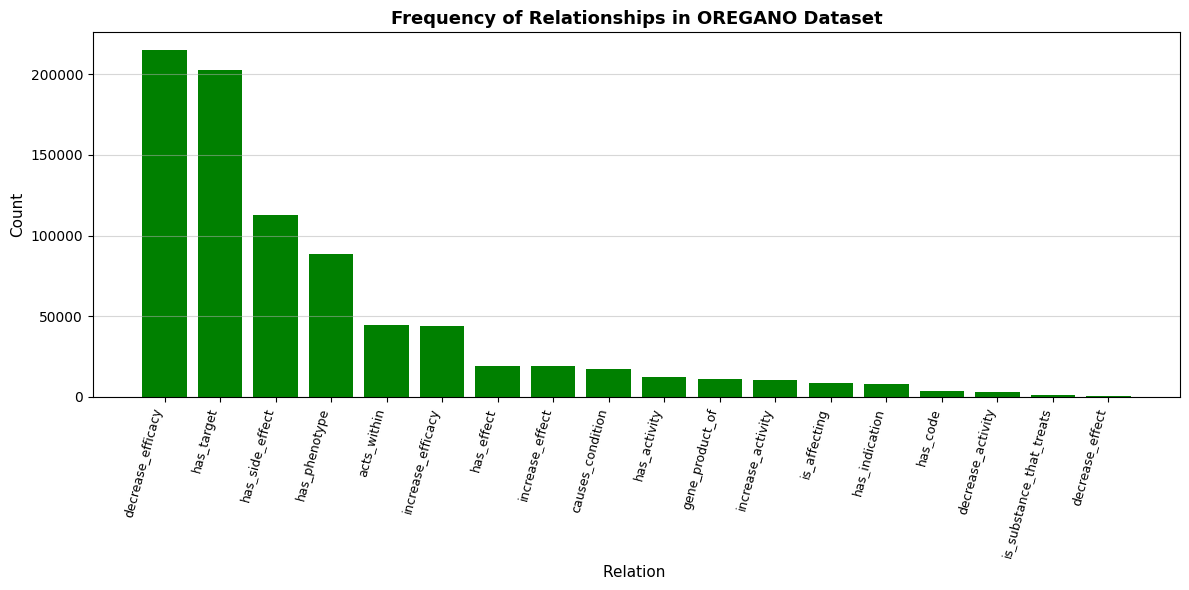

In [5]:
# Sorting relations by count in descending order
relation_counts = relation_counts.sort_values(by="Count", ascending=False)

# Defining figure size and bars of the Histogram
plt.figure(figsize=(12, 6))
plt.bar(relation_counts["Relation"], relation_counts["Count"], color="" \
"green")

# Adding rotation for X labels, X and Y label title, and graph title
plt.xticks(rotation=75, ha='right', fontsize=9)
plt.ylabel("Count", fontsize=11)
plt.xlabel("Relation ", fontsize=11)
plt.title("Frequency of Relationships in OREGANO Dataset", fontsize=13, fontweight='bold')

# Plotting the graph
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


**Findings** : 

 We can see the distribution of the relationships/predicate. These reationships will act as the edges between the nodes. Although there are only 14 unnique relationships, the total number of relationships in the OREGANO dataset are over 82,000. 

---

# Q2.

Defining a hepler function `get_type()` that extracts the type of the node. Since all nodes have the format `Node_Type : Code`, whether it is a subject or an object. This function splits the node name and returning the text that is before the colon. This operation successfully gets the node type of almost all subjects and objects. 

However there is an exception - the object for the relationship `has_code`, which does not have a colon, just the code. So for this exception this function employs an exception, and names all nodes which dont follow the naming convention to be named as `OBJECT_CODE`

In [6]:
def get_type(node):
    if ":" in node:
        return node.split(":", 1)[0] # Spliting the node name and returning what is before the ':'
    else:
        return "OBJECT_CODE"         # Adding the exception for the OBJECT_CODE

Appying the `get_type()` function on both subject and object columns using the `.apply()` method of pandas to get just the node type from each column of subjects and objects.

This series is filled with the nodes of all of the subject/object nodes. Using the `.count()` method we create another series that contains the number of the unique relations. The axis is appropriately names Subject/Object type. Finally, The series is convereted back in to a DataFrame and the Count series is added as a column.

The resulting table gives us the count of the node types, seperated by their type.

In [7]:
subject_types = oregano_df['subject'].apply(get_type)
subject_type_counts = (
    subject_types.value_counts()  # Counting the subject's occourences
    .rename_axis("Subject Type")  # Renaming the column name
    .reset_index(name="Count")    # Convert the series back into a dataframe and adding the count column 
)

object_types = oregano_df['object'].apply(get_type)
object_type_counts = (
    object_types.value_counts()   # Counting the object's occourences
    .rename_axis("Object Type")   # Renaming the column name
    .reset_index(name="Count")    # Convert the series back into a dataframe and adding the count column 
)

print("Subject Node Types and Counts :\n", subject_type_counts)
print("\nObject Node Types and Counts :\n", object_type_counts)


Subject Node Types and Counts :
   Subject Type   Count
0     COMPOUND  661181
1      DISEASE   88791
2         GENE   62152
3      PROTEIN   10881

Object Node Types and Counts :
     Object Type   Count
0      COMPOUND  259336
1       PROTEIN  202212
2   SIDE_EFFECT  112532
3     PHENOTYPE   88791
4       PATHWAY   44865
5        EFFECT   38414
6      ACTIVITY   26433
7          GENE   19786
8       DISEASE   18681
9    INDICATION    8225
10  OBJECT_CODE    3403
11     MOLECULE     327


##### Histogram

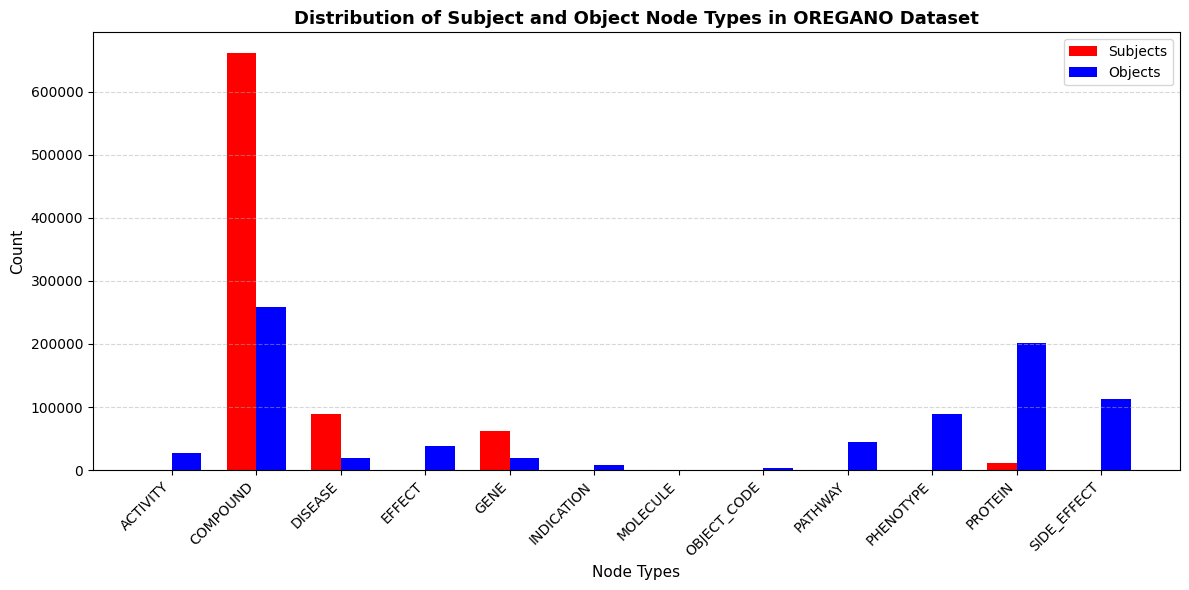

In [8]:
# Aligning all unique node types 
all_types = sorted(set(subject_type_counts["Subject Type"]) | set(object_type_counts["Object Type"]))

# Match counts to node types (fill missing with 0)
subject_counts = [subject_type_counts.set_index("Subject Type").Count.get(t, 0) for t in all_types]
object_counts = [object_type_counts.set_index("Object Type").Count.get(t, 0) for t in all_types]

# Setting the plot
x = np.arange(len(all_types))
bar_width = 0.35 

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, subject_counts, bar_width, label="Subjects", color="red")  
plt.bar(x + bar_width/2, object_counts, bar_width, label="Objects", color="blue")    

# Adding the X axis rotation, X and Y labels, the title, and the legend
plt.xticks(x, all_types, rotation=45, ha="right")
plt.xlabel("Node Types", fontsize=11)
plt.ylabel("Count", fontsize=11)
plt.title("Distribution of Subject and Object Node Types in OREGANO Dataset", fontsize=13, fontweight="bold")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Findings** :

This colour-coded histogram simply shows the distriution of each node, where `Compound` has the highest frequency while `Molecule` has the lowest.

----

# Q3.

Extracting the node type of both the subject and object columns and adding them in to the `oregano_df` DataFrame

In [9]:
oregano_df["subject_node"] = oregano_df["subject"].map(get_type)
oregano_df["object_node"] = oregano_df["object"].map(get_type)


Since each node is tied to another node with a relation, the table produced reflects this by grouping the nodes that occour in a relationship together so that we can see how often each subject node is in each type of relationship, along with the object node it is pointing to; Counting the number of times two sets of nodes occour in a relationship together.


In [10]:
relation_table = oregano_df.groupby(["predicate", "subject_node", "object_node"]).size().reset_index(name="count")

print("Table 1: Relation vs Node (Subject & Object) Type Table:")
print(relation_table)

Table 1: Relation vs Node (Subject & Object) Type Table:
                   predicate subject_node  object_node   count
0                acts_within         GENE      PATHWAY   44865
1           causes_condition         GENE      DISEASE   17287
2          decrease_activity     COMPOUND     ACTIVITY    3331
3            decrease_effect     COMPOUND       EFFECT     255
4          decrease_efficacy     COMPOUND     COMPOUND  215222
5            gene_product_of      PROTEIN         GENE   10881
6               has_activity     COMPOUND     ACTIVITY   12584
7                   has_code     COMPOUND  OBJECT_CODE    3403
8                 has_effect     COMPOUND       EFFECT   19160
9             has_indication     COMPOUND   INDICATION    8225
10             has_phenotype      DISEASE    PHENOTYPE   88791
11           has_side_effect     COMPOUND  SIDE_EFFECT  112532
12                has_target     COMPOUND     MOLECULE     327
13                has_target     COMPOUND      PROTEIN  20221

To count each individual node in a relationship, the code cells below provide the appropriate tables for subject and objects, and how often each appears in a relationship seperately.

In [11]:
relation_table_subject = oregano_df.groupby(["predicate", "subject_node"]).size().reset_index(name="count")

print("Table 2 : Relation - Subject Count Table:")
print(relation_table_subject, "\n")

Table 2 : Relation - Subject Count Table:
                   predicate subject_node   count
0                acts_within         GENE   44865
1           causes_condition         GENE   17287
2          decrease_activity     COMPOUND    3331
3            decrease_effect     COMPOUND     255
4          decrease_efficacy     COMPOUND  215222
5            gene_product_of      PROTEIN   10881
6               has_activity     COMPOUND   12584
7                   has_code     COMPOUND    3403
8                 has_effect     COMPOUND   19160
9             has_indication     COMPOUND    8225
10             has_phenotype      DISEASE   88791
11           has_side_effect     COMPOUND  112532
12                has_target     COMPOUND  202539
13         increase_activity     COMPOUND   10518
14           increase_effect     COMPOUND   18999
15         increase_efficacy     COMPOUND   44114
16              is_affecting     COMPOUND    8905
17  is_substance_that_treats     COMPOUND    1394 



In [12]:
relation_table_object = oregano_df.groupby(["predicate", "object_node"]).size().reset_index(name="count")

print("Table 3 : Relation - Object Count Table:")
print(relation_table_object, "\n")

Table 3 : Relation - Object Count Table:
                   predicate  object_node   count
0                acts_within      PATHWAY   44865
1           causes_condition      DISEASE   17287
2          decrease_activity     ACTIVITY    3331
3            decrease_effect       EFFECT     255
4          decrease_efficacy     COMPOUND  215222
5            gene_product_of         GENE   10881
6               has_activity     ACTIVITY   12584
7                   has_code  OBJECT_CODE    3403
8                 has_effect       EFFECT   19160
9             has_indication   INDICATION    8225
10             has_phenotype    PHENOTYPE   88791
11           has_side_effect  SIDE_EFFECT  112532
12                has_target     MOLECULE     327
13                has_target      PROTEIN  202212
14         increase_activity     ACTIVITY   10518
15           increase_effect       EFFECT   18999
16         increase_efficacy     COMPOUND   44114
17              is_affecting         GENE    8905
18  is_su

**Findings** :

If we look carefully at the tables produced above we can see that the relationship `has_target` appears twice with the subject `COMPOUND`, once with `MOLECULE` and once with `PROTIEN`, which is why the Tables 1 and 3 have 19 rows and table 2 has only 18. This is because the `has_target` is only such relation that exhibits such a behaviour. So the majority of the relationships are one to one, and only `has_target` is one to many. 


----

# Q4. 

Creating a new ontology using a dummy URL.


In [13]:
onto = get_ontology("http://www.dummy.info/new.owl")

Populating the ontology using the `oregano_df` by defining the ontology and filling it with nodes and their relationships.

In [14]:
with onto:
    # Step 1 - Declaring the ontology dictionary and running a loop over the flattened `subject` & `object` nodes to find all the unique nodes in the dataset. 
    # Then a new OWL class is created for each node using the `types` key word, inheriting from the base class `Thing`. This OWL class is then stored in the dictionary
    # as the value for the key of the paticular node. Now, each node has its own class.
    ontology_dict = {}
    for node_type in pd.unique(oregano_df[['subject_node', 'object_node']].values.ravel('K')):
            ontology_dict[node_type] = types.new_class(node_type, (Thing,))

    # Step 2 - Declaring the relationships dictionary and running a for loop over all the unique predicate/relationships in the data. 
    # Again, using the `Thing` keyword, a new OWL class is created, which inherits from `ObjectProperty`. The ObjectProperty is used to link instances if classes, like subejects and objects. 
    # This is stored in the dictrionary as the value of the key of the paticular predicate. Now, each predicate is represented as an OWL object property

    relation_dict = {}
    for rel in oregano_df['predicate'].unique():
        relation_dict[rel] = types.new_class(rel, (ObjectProperty,))

    # Step 3 - The data is grouped by each relation and a loop is run for this grouped data. The `subject_nodes` and `object_nodes` are lists of string that 
    # hold the unique subject and object nodes for that relation. Then a nested for loop for each combination of subject and object assigns the domain of the relationship,
    # which is the subject class, and the range of the relationship, which is the object class. After this, each relation is linked to each class to which it connects to. 

    for rel, group in oregano_df.groupby('predicate'):
        subject_nodes = group['subject_node'].unique()
        object_nodes = group['object_node'].unique()
        for s in subject_nodes:
            for o in object_nodes:
                if s in ontology_dict and o in ontology_dict:
                    relation_dict[rel].domain.append(ontology_dict[s])
                    relation_dict[rel].range.append(ontology_dict[o])

# Step 4 - Finally the `.save()` writes the ontology as a .owl file which can be viewed and used later on 
onto_path = "./oregano_ontology.owl"
onto.save(file=onto_path) 
print(f"Ontology saved as : {onto_path}")


Ontology saved as : ./oregano_ontology.owl


Generating the graph using `PyVis` by adding the subject and object nodes and connecting them using the relationships. 


In [15]:
# Creating a PyVis network and defining its size and colours
net = Network(height="800px", width="100%", directed=True, bgcolor="#ffffff", font_color="black")

# Seperating the subject and object nodes into sets, which makes all instances inside unique
subject_nodes = set()
object_nodes = set()

for _, row in oregano_df.iterrows():
    subject_nodes.add(row['subject_node'])
    object_nodes.add(row['object_node'])

# Adding nodes into the network from the ontology `ontology_dict`
for node_type in ontology_dict.keys():
    if node_type in subject_nodes:
        color = "#ff4d4d"               # red shades for subjects
    elif node_type in object_nodes:
        color = "#3399ff"               # blue shades for objects

    net.add_node(node_type, label=node_type, color=color, title=node_type)

# Adding edges, including edges for those nodes with multiple edges. Using set() to make the entries unique
added_edges = set()

for rel, prop in relation_dict.items():
    for domain in prop.domain:
        for range_ in prop.range:
            edge_key = (domain.name, range_.name, rel)
            if edge_key not in added_edges:
                net.add_edge(domain.name, range_.name, label=rel, title=rel, color="#8d8d8d")
                added_edges.add(edge_key)


# Setting the graph physics
net.barnes_hut(gravity=-25000, central_gravity=0.2, spring_length=120, spring_strength=0.04, damping=0.9)

output_path = "oregano_ontology.html"
net.write_html(output_path)
print("Ontology visualization saved as :", output_path)


Ontology visualization saved as : oregano_ontology.html


**Difficulty Enountered** : 

When the graph was visualised using `NetworkX`, all of the edges werent being visualised correctly as only 14 edge were being visualised. Upon further inspection it was discovered that NetworkX over-writes the nodes between two nodes if there exists more than one node between them. Using the `MultiGraph` the issue still wasnt resolved. The graph produced was also static and not interactible. This led to the use of `PyVis` which accurately plotted the graph and allowed for interation.

**Findings :**
 
This colour-colded visualisation shows us the 3 subjects and their relationships with the 8 object nodes and the 18 directed relationships between them, some of which are circular. There are also some node pairs which have more than one relationship between them.

----

# Q5.

Modeling the ontology using Fist Order Logic. We do this by calculating the frequency  of each relationship with it's nodes and associating it with the approopriate quantifier.

In [16]:
fol_statements = []
universal_count = 0
existential_count = 0
mixed_count = 0

# Looping though the `oregano_df` grouped by the predicate/relationships.
for rel, group in oregano_df.groupby('predicate'):
    # Extracting all the nodes of that relationship
    subject_nodes = group['subject_node'].unique()
    object_nodes = group['object_node'].unique()

    # Iterating through the suject and object nodes in a nested for loop
    for s in subject_nodes:
        for o in object_nodes:
            #  Counting how often this specific subject-object pair appears for this relation. 
            num_edges = len(group[(group['subject_node'] == s) & (group['object_node'] == o)])

            # Counting the total occourances of the patiular subject node in the dataset, across all relationships.
            total_subj_nodes = len(oregano_df[oregano_df['subject_node'] == s])
            
            freq = num_edges / total_subj_nodes if total_subj_nodes > 0 else 0

            # Assign proper FOL quantifier forms
            if freq > 0.9:
                # Universal: all x of type s relate to some y of type o
                quant = f"∀x ({s}(x) → ∃y ({o}(y) ∧ {rel}(x, y)))"
                universal_count += 1
            elif freq > 0.2:
                # Mixed quantifier: some x relate to some y
                quant = f"∃x∃y ({s}(x) ∧ {o}(y) ∧ {rel}(x, y))"
                mixed_count += 1
            else:
                # Pure existential: there exists at least one x, y such that rel(x, y)
                quant = f"∃x∃y ({s}(x) ∧ {o}(y) ∧ {rel}(x, y))"
                existential_count += 1

            fol_statements.append(quant)

# Print sample FOL statements
print("Sample FOL statements:\n")
for statement in fol_statements:
    print(statement)

# Summary
print("\n\nSummary:")
print("Universal quantifiers (∀):", universal_count)
print("Mixed quantifiers (∃x∃y):", mixed_count)
print("Existential quantifiers (∃):", existential_count)


Sample FOL statements:

∃x∃y (GENE(x) ∧ PATHWAY(y) ∧ acts_within(x, y))
∃x∃y (GENE(x) ∧ DISEASE(y) ∧ causes_condition(x, y))
∃x∃y (COMPOUND(x) ∧ ACTIVITY(y) ∧ decrease_activity(x, y))
∃x∃y (COMPOUND(x) ∧ EFFECT(y) ∧ decrease_effect(x, y))
∃x∃y (COMPOUND(x) ∧ COMPOUND(y) ∧ decrease_efficacy(x, y))
∀x (PROTEIN(x) → ∃y (GENE(y) ∧ gene_product_of(x, y)))
∃x∃y (COMPOUND(x) ∧ ACTIVITY(y) ∧ has_activity(x, y))
∃x∃y (COMPOUND(x) ∧ OBJECT_CODE(y) ∧ has_code(x, y))
∃x∃y (COMPOUND(x) ∧ EFFECT(y) ∧ has_effect(x, y))
∃x∃y (COMPOUND(x) ∧ INDICATION(y) ∧ has_indication(x, y))
∀x (DISEASE(x) → ∃y (PHENOTYPE(y) ∧ has_phenotype(x, y)))
∃x∃y (COMPOUND(x) ∧ SIDE_EFFECT(y) ∧ has_side_effect(x, y))
∃x∃y (COMPOUND(x) ∧ PROTEIN(y) ∧ has_target(x, y))
∃x∃y (COMPOUND(x) ∧ MOLECULE(y) ∧ has_target(x, y))
∃x∃y (COMPOUND(x) ∧ ACTIVITY(y) ∧ increase_activity(x, y))
∃x∃y (COMPOUND(x) ∧ EFFECT(y) ∧ increase_effect(x, y))
∃x∃y (COMPOUND(x) ∧ COMPOUND(y) ∧ increase_efficacy(x, y))
∃x∃y (COMPOUND(x) ∧ GENE(y) ∧ is_affec

**Difficulty Encountered** :

Since an OWL ontology cannot be converted directlly into FOL using a built-in function, coding it seemed like a challenge. But since FOL is essentially telling us about the frequency of occourences, we can try to count the number of occourences of a relationship and convert it into the frequency using basic mathamatical manipulation. This gives a value between 0 and 1. For all those relationships that occour over 90% we accociate it with the `∀` quantifier, for those between 90% and 20% the `∃x∃y` quantifier is associated with it. And finally for the rarest occourences, less than 20%, `∃` quantifier is associated  with them. To summarise it, the FOL implemented here is a frequency counter. 

**Findings** :

- Compound appears the most in relationships, which is to be expected as it has the highest number of nodes in the dataset. So can deduce that the dataset is drug centric; it is modelling the interactions of drugs with genes, diseases, etc.

- Majority of the relationships exhibit a `∃` quantifier which occours 13 times, which is to be expected as all the subject nodes are spread in terms of their relationships, not limited to just one relatioship. The `∀` quantifier is the least common, with ony 2 relationships exhibiting this, namely the `gene_product_of` and the `has_phenotype` relationships. The `Many` quantifier is in the middle with 4 occourences


---

# Q6. 

NOTE : Creating and viewing an interactive graph using Pyvis of the whole dataset is not possible as the dataset has over 820,000 lines, which equates to a huge HTML file that does not open. Which is why for the following approach we are using a seed value to create a subset of the original data so that the resultant graph created is viewable and renders in a normal laptop.  

In [ ]:
# Creating a subset of the DataFrame using 3000 samples and the seed value defined above
oregano_df_sample = oregano_df.sample(n=3000, random_state=SEED)

# Defining the network's colour, size, and other properties are defined, as well as the physics of the gavity and edge lengths
net = Network(height="900px", width="100%", bgcolor="#222222", font_color="white", directed=True)
net.barnes_hut(gravity=-25000, central_gravity=0, spring_length=120, spring_strength=0.04, damping=0.9)

# Defining the subject and object node colours in shades of red and blue respectively.
color_map = {
    # Subjects 
    "COMPOUND": "#ff4d4d",   
    "DISEASE": "#e60000",    
    "GENE": "#b30000",       
    "PROTEIN": "#800000",    

    # Objects 
    "SIDE_EFFECT": "#99ccff", 
    "PHENOTYPE": "#6699ff",   
    "ACTIVITY": "#3366ff",    
    "EFFECT": "#0033cc",      
    "MOLECULE": "#001a66",    
    "INDICATION": "#80bfff",  
    "PATHWAY": "#4da6ff",     
    "OBJECT_CODE": "#cce6ff" 
}

# Iterate over each triple (subject, predicate, object), add nodes for subject & object with colors by type, and connect them with an edge labeled by the relationship.
for _, row in oregano_df_sample.iterrows():
    subj, obj, rel = row['subject'], row['object'], row['predicate']
    subj_type, obj_type = row['subject_node'], row['object_node']
    net.add_node(subj, label=subj, title=subj_type, color=color_map.get(subj_type))
    net.add_node(obj, label=obj, title=obj_type, color=color_map.get(obj_type))
    net.add_edge(subj, obj, title=rel, color="#aaaaaa")

# Saving the graph as an HTML file
output_path = "oregano_graph_sample.html"
net.write_html(output_path)
print(f"Subset knowledge graph exported as : {output_path}")


Subset knowledge graph exported as : oregano_graph_sample.html


**Difficulty Encountered** :

This code is for making a graph using all 820,000 relationships. It created a file of 126MB, which does not open even on a laptop with 32 GB RAM. Many attempts have been made to render this file such as :
- Uploading to GitHub and hosting the HTML file from there - The file size is too large to push.
- Uploading to LimeWire - The file was successfully uploaded but doesnt open.
- Using a python server that loads HTML files more efficently - This method crashes my laptop.
- Using a Desktop PC in CSB - The file fails to load.

Although this file can be created, but it does not load.

In [37]:
net = Network(height="900px", width="100%", bgcolor="#222222", font_color="white", directed=True)
net.barnes_hut(gravity=-25000, central_gravity=0, spring_length=120, spring_strength=0.04, damping=0.9)

color_map = {
    # Subjects 
    "COMPOUND": "#ff4d4d",   
    "DISEASE": "#e60000",    
    "GENE": "#b30000",       
    "PROTEIN": "#800000",    

    # Objects 
    "SIDE_EFFECT": "#99ccff", 
    "PHENOTYPE": "#6699ff",   
    "ACTIVITY": "#3366ff",    
    "EFFECT": "#0033cc",      
    "MOLECULE": "#001a66",    
    "INDICATION": "#80bfff",  
    "PATHWAY": "#4da6ff",     
    "OBJECT_CODE": "#cce6ff" 
}

for _, row in oregano_df.iterrows():
    subj, obj, rel = row['subject'], row['object'], row['predicate']
    subj_type, obj_type = row['subject_node'], row['object_node']
    net.add_node(subj, label=subj, title=subj_type, color=color_map.get(subj_type))
    net.add_node(obj, label=obj, title=obj_type, color=color_map.get(obj_type))
    net.add_edge(subj, obj, title=rel, color="#aaaaaa")

output_path = "oregano_graph_FULL.html"
net.write_html(output_path)
print(f"Subset knowledge graph exported as : {output_path}")


Subset knowledge graph exported as : oregano_graph_FULL.html


#### Sources
- [Scientific Data - nature.com](https://www.nature.com/articles/s41597-023-02757-0)
- [NAID - The OREGANO knowledge graph for computational drug repurposing](https://data.niaid.nih.gov/resources?id=zenodo_10103841)
- [University of Bordeaux - gitlab](https://gitub.u-bordeaux.fr/erias/oregano)
- [PyVis Documentation](https://pyvis.readthedocs.io/en/latest/documentation.html)
- [OwlReady2 Documentation](https://owlready2.readthedocs.io/en/v0.48/)

### This file contains 1095 words in the markdown cells, excluding this sentence and the sources